## Results
This notebook will summarize the results of the final model selected in the model selection process.

1. Determine the right probability to cutoff to minimize cost incurred from a false positive or false negative
2. Develop the baseline non-ML model to compare against my final model
3. Develop a process to suggest how to enhance a review to encourage a product to trend.

In [12]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_predict

import numpy as np
import pandas as pd
import dill

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

MODELING_PATH = '../data/modeling/'
PATH = '../data/amazon_reviews_us_Toys_v1_00.tsv'

In [6]:
# save progress
def save(obj, obj_name):
    f = MODELING_PATH + obj_name
    dill.dump(obj, open(f, 'wb'))

def load(obj_name):
    f = MODELING_PATH + obj_name
    return dill.load(open(f, 'rb'))

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
from AmazonReviews import AmazonReviews

ar = AmazonReviews()

In [30]:
ar.load_data(PATH)
ar.calc_trend_score()
ar.create_observations()
ar.create_train_test_split()

Read from pickle...


In [14]:
final_model = load('final_model_smote_5t.pkl') 

ar.y_train = load('y_train.pkl')
ar.X_train = load('X_train.pkl')

X_train_transformed = load('X_train_transformed.pkl') # transformed X_train via CountVect and LDA (5 topics)

## Minimize cost of FPR and FNR

* A false positive error is equivalent to the model classifying a product as trending, but actually does not trend. This would be a scenario where the foecast could be lifted due to this signal and resulting in excess inventory.
* A false negative error is equivalent to the model classiying a product as not trending, but actually does trend. This is the scenario where the forecast is not lifted due to this signal, resulting in stock-outs and lost sales as the product is trending.

The cost of a false negtive rate significantly outweighs the cost of a false postive rate. In fact, correctly identifying the products that will trend should reduce the cost the associated with a false positive, i.e. excess inventory.

Let's assume we have a generic toy with COGS of \$10, a standard monthly inventory holding rate of 1.6%, and a markup of 100%. The error costs would be calcualted as,

* False Postive Cost = COGS \* holding = 10 * .016= \$0.16
* False Negative Cost = COGS \* markup = 10 * (1.5) = \$15

In [9]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

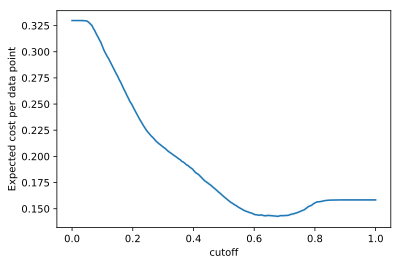

In [35]:
cut = np.linspace(0,1,200)
cost = np.zeros_like(cut)

K = 5
cogs = 10
inv_holding = .2
months_held = 2
markup_percent = 0.5

fp_cost = cogs * (inv_holding / 12 * months_held)
fn_cost = cogs * (1 + markup_percent)

for j in range(K):
    folds = StratifiedKFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(
                                final_model,
                                X_train_transformed,
                                ar.y_train,
                                cv=folds,
                                method='predict_proba',
                                n_jobs=-1)[:,1]
    
    getcost = makecost(
        ar.y_train,
        prob,
        falsepos_cost=fp_cost,
        falseneg_cost=fn_cost)
    
    currentcost = getcost(cut)/X_train_transformed.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)

cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [36]:
y_probs = final_model.predict_proba(X_train_transformed)[:,1]
y_score = (y_probs >= cut[np.argmin(cost)]).astype(int)

print(metrics.confusion_matrix(ar.y_train, y_score))
print(cut[np.argmin(cost)])

[[139824  16903]
 [  1063    610]]
0.678391959798995


## Cost Analysis Summary

Assuming a simple COGS of 100 per unit with an annual inventory holding cost of 20% and a profit margin of 44% for a trending product, then the cost tradeoff is the lost sale or holding inventory. The cost to hold inventory would be \$1.6 per month vs a \$144 lost sale. 

## Baseline model

A baseline model would be to look at all reviews which occured on the day of the first review and calculate the average rating of the reviews. If the average rating is greater than or equal to 4, then the prediction will be the product will trend.

In [37]:
# load the data and perform train / test split
ar.load_data(PATH)
ar.calc_trend_score()
ar.create_observations()
ar.create_train_test_split()

Read from pickle...


In [38]:
ar.obs.head()

,product_id,review_date,review_id,review_body,trend
0,0000031860,2014-12-28,R2Z8FGO6W1S0AO,Met my expectations.Thank you!,0
1,0000031887,2015-05-24,RM1D9I5N2RIQE,It's ok. Not as fluffy as appears in photo,0
2,0000031895,2014-03-31,R32KKQEJRY9O28,This tutu is completely see-through. I bought ...,0
3,0298770423,2015-07-20,R1MVAAE8U5VNPI,Exactly what I wanted. Greeting shipping speed...,0
4,029877044X,2015-07-31,R1FANJQ8Q3OYA,My son was very happy with this toy.,0
